In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import scripts.read_data_from_db as rd
import scripts.data_cleaning as dc
import scripts.write_to_db as wd
import scripts.utils as util

In [2]:
df = rd.read_data(table_name='processed_data')

INFO:scripts.read_data_from_db:Data fetched succesfully


In [3]:
pysqldf = lambda q: sqldf(q, globals())

## User Engagement Analysis

### Session Frequency per user

In [4]:
query = ''' 
        SELECT
            "MSISDN/Number" AS MSISDN,
            COUNT(DISTINCT "Bearer Id") AS SessionFrequency
        FROM df
        GROUP BY "MSISDN/Number"
        ORDER BY SessionFrequency DESC
        LIMIT 10
'''

result_df = pysqldf(query)
result_df

,MSISDN,SessionFrequency
0,3.362632e+10,520
1,3.362578e+10,17
2,3.361489e+10,17
3,3.365973e+10,16
4,3.376054e+10,15
5,3.367588e+10,15
6,3.366716e+10,13
7,3.376041e+10,12
8,3.362708e+10,12
9,3.360452e+10,12


### Session duration per user

In [5]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration
    FROM df
    GROUP BY "MSISDN/Number" 
    ORDER BY SessionDuration DESC
    LIMIT 10;
    ''' 

result_df = pysqldf(query)
result_df


,MSISDN/Number,SessionDuration
0,3.362632e+10,81238323.0
1,3.362578e+10,18553754.0
2,3.361489e+10,9966898.0
3,3.376054e+10,9279434.0
4,3.366716e+10,8744914.0
5,3.366284e+10,6614270.0
6,3.366469e+10,6288730.0
7,3.360313e+10,6287761.0
8,3.366746e+10,5649882.0
9,3.376041e+10,5321667.0


### Median of the sessions durations

In [6]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration
    FROM df
    GROUP BY "MSISDN/Number" 
    ORDER BY SessionDuration DESC;
    ''' 

result_df = pysqldf(query)
result_df['SessionDuration'].median()

102740.0

### Total traffic per user

In [7]:
query = ''' 
    SELECT 
        "MSISDN/Number",
        SUM("Total DL (Bytes)") AS TotalDownload,
        SUM("Total UL (Bytes)") AS TotalUpload,
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ORDER BY TotalTraffic DESC
    LIMIT 10;
'''

pysqldf(query)

,MSISDN/Number,TotalDownload,TotalUpload,TotalTraffic
0,3.362632e+10,4.942252e+11,4.499495e+10,5.392201e+11
1,3.361489e+10,8.156743e+09,6.894830e+08,8.846226e+09
2,3.376054e+10,7.811295e+09,7.034786e+08,8.514774e+09
3,3.362578e+10,7.770043e+09,7.295774e+08,8.499621e+09
4,3.367588e+10,7.309542e+09,5.815688e+08,7.891111e+09
5,3.365973e+10,7.081602e+09,6.242603e+08,7.705863e+09
6,3.366646e+10,6.903440e+09,4.050610e+08,7.308501e+09
7,3.376041e+10,6.610852e+09,5.215189e+08,7.132371e+09
8,3.366471e+10,6.400774e+09,4.712445e+08,6.872018e+09
9,3.369879e+10,6.010556e+09,5.303431e+08,6.540899e+09


### Median Total trafic of user

In [8]:
query = ''' 
    SELECT 
        "MSISDN/Number",
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ORDER BY TotalTraffic DESC
'''

pysqldf(query)['TotalTraffic'].median()

617923138.0

### Aggregating engagement metrics

In [9]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration,
        COUNT(DISTINCT "Bearer Id") AS SessionFrequency,
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ''' 

aggregated_df = pysqldf(query)
aggregated_df.tail()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
106851,3.379000e+10,8810.0,1,714641641.0
106852,3.379000e+10,140988.0,1,480307335.0
106853,3.197021e+12,877385.0,1,232123971.0
106854,3.370000e+14,253030.0,1,596287824.0
106855,8.823971e+14,869844.0,1,139153646.0


### handle outliers

In [10]:
aggregated_df = dc.handle_outliers(aggregated_df, ["SessionDuration","SessionFrequency","TotalTraffic"])

### Normalize engagement metrics

In [11]:
scaler = MinMaxScaler()
columns_to_normalize = ["SessionDuration", "SessionFrequency","TotalTraffic"]
customer_id = aggregated_df['MSISDN/Number']
transformed_data = scaler.fit_transform(aggregated_df[columns_to_normalize])
normalized_data = pd.DataFrame(transformed_data, columns=columns_to_normalize)
df_normalized = pd.concat([customer_id, normalized_data], axis=1)
df_normalized

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
0,3.360100e+10,0.275973,0.0,0.508721
1,3.360100e+10,0.460555,0.0,0.017328
2,3.360100e+10,0.328189,0.0,0.316254
3,3.360101e+10,0.084717,0.0,0.198043
4,3.360101e+10,0.048167,0.5,0.902690
...,...,...,...,...
106851,3.379000e+10,0.362170,0.0,0.397044
106852,3.379000e+10,0.345411,0.0,0.237518
106853,3.197021e+12,0.362170,0.0,0.068565
106854,3.370000e+14,0.665997,0.0,0.316473


### K-means clustering with k = 3

#### Plot

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_normalized['SessionDuration'], df_normalized['SessionFrequency'], df_normalized['TotalTraffic'], c='blue', marker='o')

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')cases = 707,443

Total deaths = 3,891
ax.set_zlabel('TotalTraffic')

plt.title('3D Scatter Plot of SessionDuration, SessionFrequency, and TotalTraffic')
plt.show()

SyntaxError: invalid syntax (497504817.py, line 7)

In [13]:
selected_columns = columns_to_normalize
X = df_normalized[selected_columns]
k = 3

kmeans = KMeans(n_clusters=3, random_state=0, n_init=25) 
kmeans.fit(X)

df_normalized['Cluster'] = kmeans.labels_

### Plot of clustered engagement

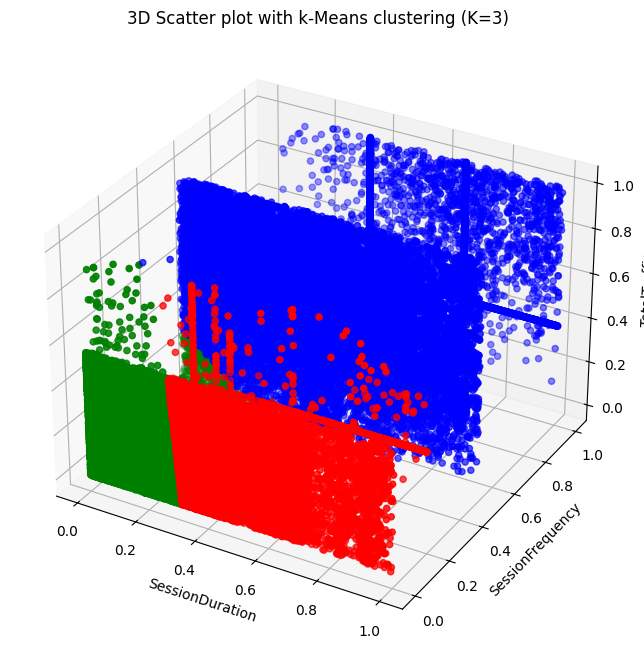

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cluster_colors = {0: 'red', 1: 'blue', 2:'green'}

for cluster_label, color in cluster_colors.items():
    cluster_data = df_normalized[df_normalized['Cluster'] == cluster_label]
    ax.scatter(
        cluster_data['SessionDuration'], 
        cluster_data['SessionFrequency'], 
        cluster_data['TotalTraffic'], 
        label=f'Cluster {cluster_label}',
        color=color
        )

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title(f'3D Scatter plot with k-Means clustering (K={k})')
plt.show()

### Minimum, Maximum, average and total in each cluster

In [15]:
grouped_df = (df_normalized
                .groupby('Cluster')[["SessionDuration", "SessionFrequency", "TotalTraffic"]]
                .agg(['min', 'max', 'mean', 'sum']))

grouped_df

SessionDuration                                   SessionFrequency  \
                    min       max      mean           sum              min   
Cluster                                                                      
0              0.266694  1.000000  0.436510  14121.539539         0.000000   
1              0.003574  0.999989  0.451518  11616.208770         0.192324   
2              0.000000  0.312403  0.150470   7339.633278         0.000000   

                                     TotalTraffic                      \
         max      mean           sum          min       max      mean   
Cluster                                                                 
0        0.5  0.015463    500.234942     0.000000  0.996441  0.293469   
1        1.0  0.579001  14895.968079     0.024170  1.000000  0.572729   
2        0.5  0.003283    160.115567     0.000082  0.997914  0.273528   

                       
                  sum  
Cluster                
0         9494.015329  
1        14734.592876  
2        13342.142646

### Grouping users in k engagement clusters using elbow method


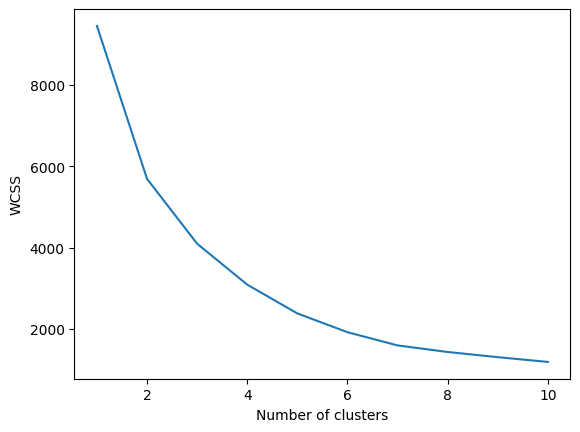

In [16]:
wcss = []
X = df_normalized.iloc[:, [1, 3]]

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##### The ideal value for K in the engagement analysis remains consistent at K = 7

### KMeans for k = 7

In [17]:
selected_columns = columns_to_normalize
X = df_normalized[selected_columns]
k = 7

kmeans = KMeans(n_clusters=k, random_state=0, n_init=25) 
kmeans.fit(X)

df_normalized['Cluster'] = kmeans.labels_

#### plot

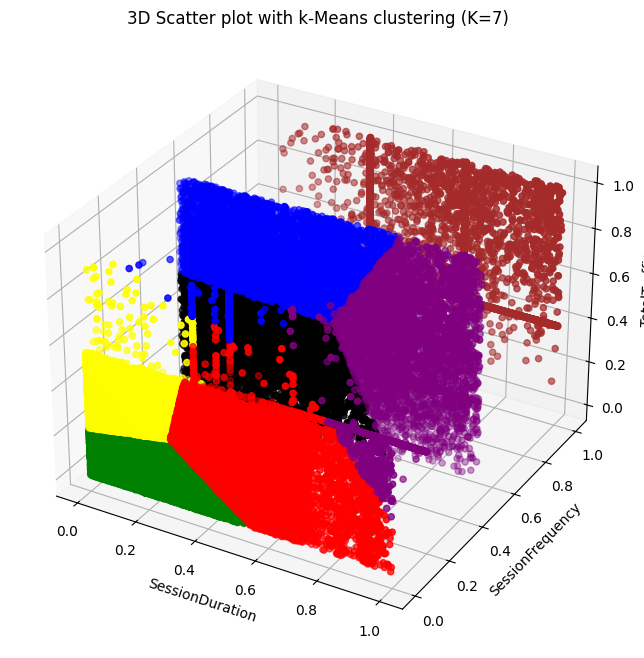

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cluster_colors = {0: 'red', 1: 'blue', 2:'green', 3:'black', 4:'yellow', 5:'brown', 6:'purple'}

for cluster_label, color in cluster_colors.items():
    cluster_data = df_normalized[df_normalized['Cluster'] == cluster_label]
    ax.scatter(
        cluster_data['SessionDuration'], 
        cluster_data['SessionFrequency'], 
        cluster_data['TotalTraffic'], 
        label=f'Cluster {cluster_label}',
        color=color
        )

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title(f'3D Scatter plot with k-Means clustering (K={k})')
plt.show()

#### write to database

In [21]:
wd.write_data(df_normalized, 'user_engagement')

INFO:scripts.write_to_db:Data written successfully
